In [12]:
import librosa
import acoustics
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from tr_augmentation import *

def subband_plots(sub_bandas, label=' '):
    fig, axs = plt.subplots(7)
    ticks_labels=['125 Hz', '250 Hz', '500 Hz', '1000 Hz', '2000 Hz', '4000 Hz', '8000 Hz']
    for banda in range(sub_bandas.shape[0]):
        axs[banda].plot(librosa.amplitude_to_db(sub_bandas[banda,:]), label='Aumentada')
        axs[banda].legend()
        axs[banda].set_title(ticks_labels[banda], fontsize=18)
    plt.subplots_adjust(right=2, top=7)

params = {'fc' : [125.0, 250.0, 500.0, 1000.0, 2000.0, 4000.0],
          'fs' : 16000,
          'filter_order' : 4,
          'filter_length' : 16384,
          'power' : True}

rir_path = '/home/martin/datasets/rir/C4DM'
audio_list = get_audio_list(rir_path)
rir_entrada, fs = librosa.load(audio_list[10], sr=16000)
TR_DESEADO = 1.5

# Proceso de aumentacion de Respuestas al Impulso

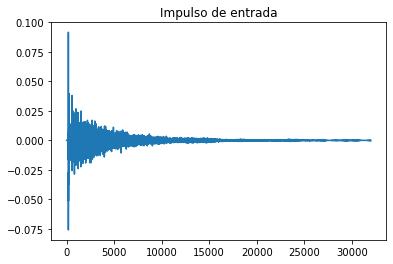

In [13]:
plt.plot(rir_entrada)
plt.title('Impulso de entrada')
plt.show()

Impulso de entrada: Se debe tener en cuenta algunos detalles como ser el hecho de que existe un delay inicial, y la amplitud es un valor arbitrario. Para hacer mas sencilla la implementacion, vamos a quitar el delay inicial y a normalizar la amplitud en 1.0. Por ahora voy a quedarme solo con la parte late sobre la que voy a trabajar en la aumentacion temporal. 

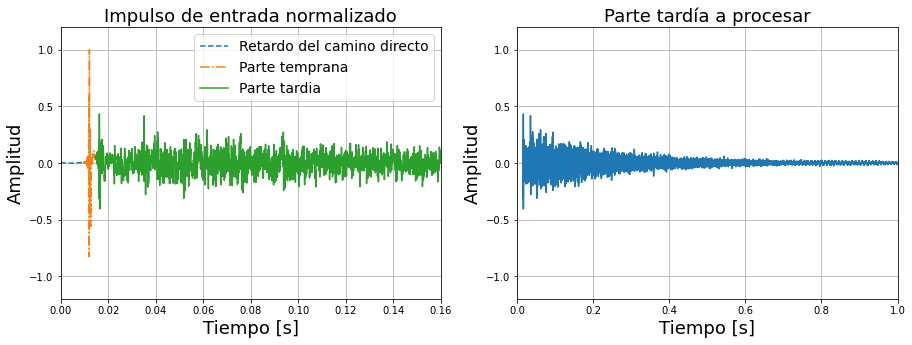

In [14]:
def normalize_rir(rir):
    #busco el valor maximo
    index_max = np.argmax(abs(rir))
    
    #Normalizo 
    rir = rir / rir[index_max]

    #Elimino el delay
    #rir = rir[index_max:]
    
    return rir
t = np.linspace(0, len(rir_entrada)/fs,len(rir_entrada))
rir_entrada = normalize_rir(rir_entrada)
delay, early, rir = temporal_decompose(rir_entrada, fs) # RIR = PARTE LATE

#AL FINALIZAR TENGO QUE CONCATENAR LA PARTE EARLY NUEVAMENTE
plt.figure(1, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(t[:len(delay)],delay, '--', label='Retardo del camino directo')
plt.plot(t[len(delay):len(delay)+len(early)], early,'-.', label='Parte temprana')
plt.plot(t[-len(rir):], rir, label='Parte tardia')
plt.ylim(-1.2,1.2)
plt.xlim(0,0.16)
plt.title('Impulso de entrada normalizado', fontsize=18)
plt.legend(prop={'size': 14})
plt.ylabel('Amplitud', fontsize=18)
plt.xlabel('Tiempo [s]', fontsize=18)
plt.grid()
plt.subplot(1,2,2)
plt.title('Parte tardía a procesar', fontsize=18)
plt.plot(t[-len(rir):], rir)
plt.ylim(-1.2,1.2)
plt.xlim(0,1)
plt.ylabel('Amplitud', fontsize=18)
plt.xlabel('Tiempo [s]', fontsize=18)
plt.grid()
plt.savefig('imagenes/impulso_entrada.png')
plt.show()

El paso siguiente es estimar los parametros de modelizacion de la caida de energia del impulso full-banda, porque luego necesito este parametro para la aumentacion del impulso por bandas. 

In [15]:
def estimated_fullband_decay(rir, fs):
    delay, early, late = temporal_decompose(rir, fs)
    late_env = get_abs_envelope(late) # window lenght = 40

    #modelo de late field reverb
    t = np.linspace(0, len(late_env)/fs, len(late_env))
    popt, popv = scipy.optimize.curve_fit(curva_modelo, t, late_env, bounds=(0,1))
    return popt[1]

estim_fullband_decay = estimated_fullband_decay(rir, fs)
print('Decay rate full-banda: {:0.2f}'.format(estim_fullband_decay))

Decay rate full-banda: 0.26


Luego necesito descomponer el audio en bandas de octava para realizar la aumentacion por bandas de manera de mantener las caracteristicas frecuenciales de la caida de enrgia. Descompongo la señal en 7 bandas

Matrix con subbandas de tamaño: (6, 31765)


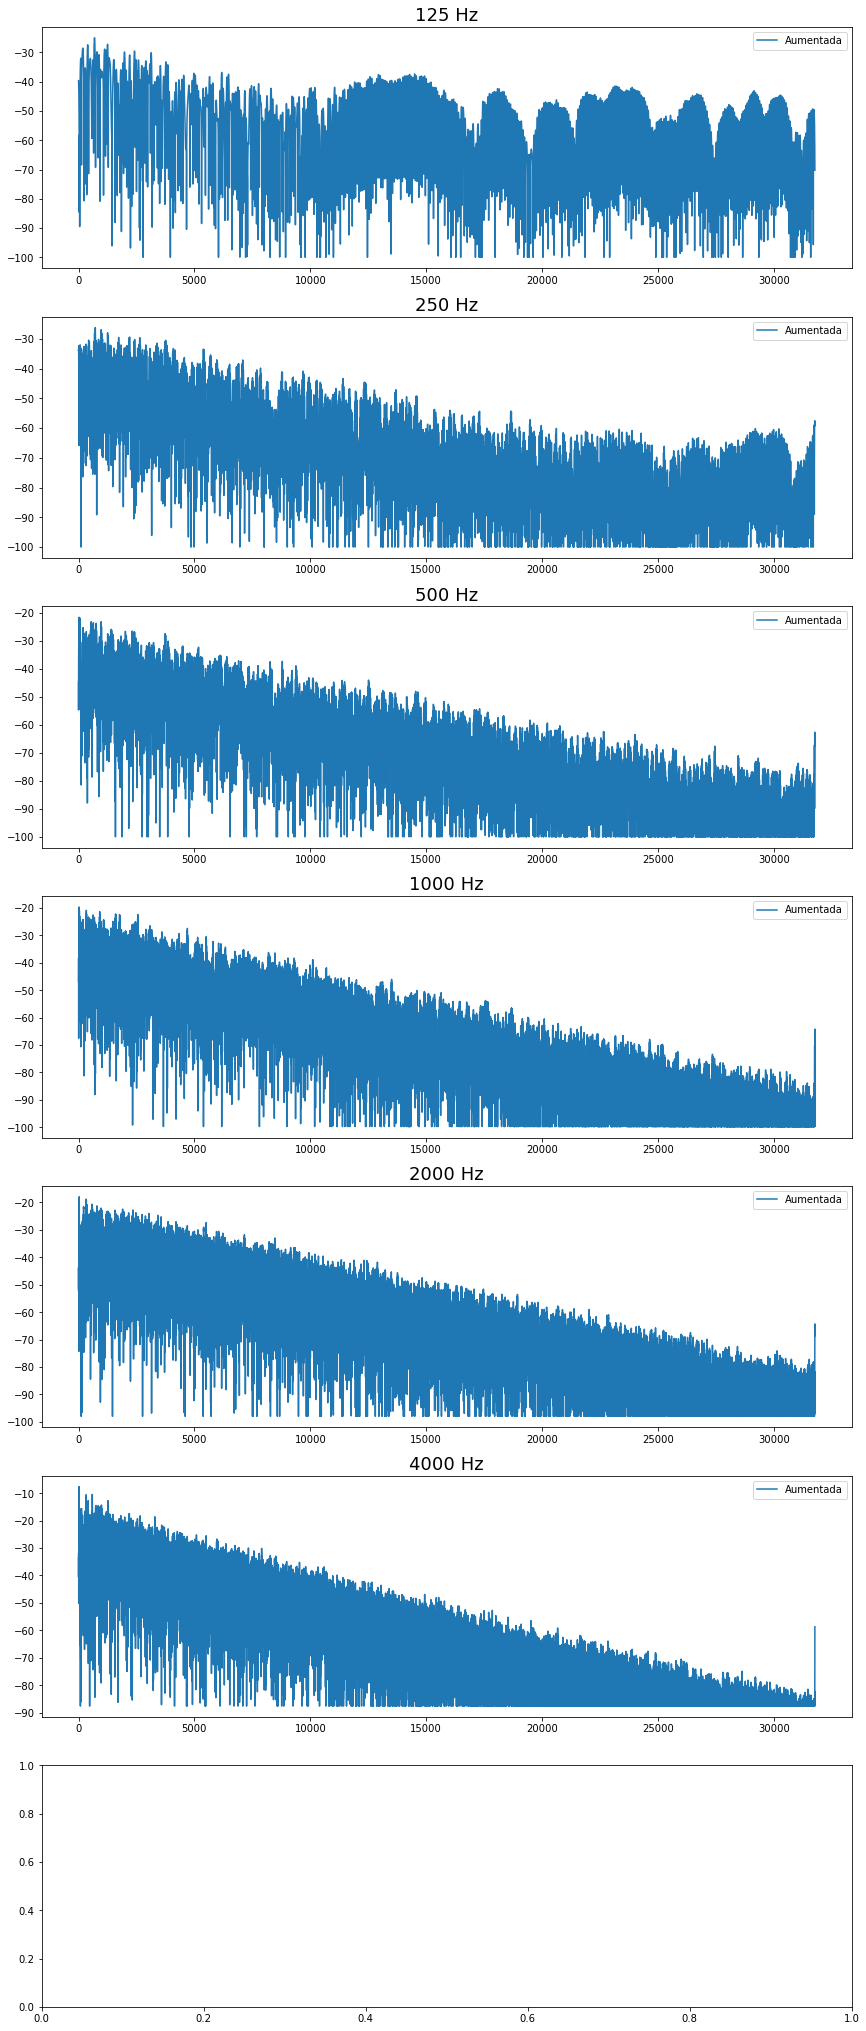

In [16]:
rir_bands = sub_band_decompose(rir, fs, params)
print('Matrix con subbandas de tamaño: '+str(rir_bands.shape))
subband_plots(rir_bands)
#sub_bandas = rir_bands

#fig, axs = plt.subplots(6, sharex = True, figsize=(15,15))
#fig.text(0.5, 0.00, 'Tiempo [s]', ha='center', size=18)
#fig.text(0.00, 0.5, 'Amplitud [dB]', va='center', rotation='vertical', size=18)
#fig.tight_layout(pad=4.0,)
#ticks_labels=['125 Hz', '250 Hz', '500 Hz', '1000 Hz', '2000 Hz', '4000 Hz', '8000 Hz']
#t = np.linspace(0,30000/16000,30000)
#for banda in range(sub_bandas.shape[0]):
#    axs[banda].plot(t,librosa.amplitude_to_db(sub_bandas[banda,:30000]))
#    axs[banda].set_title(ticks_labels[banda], fontsize=16)
#plt.savefig('imagenes/sub_bandas.png')

En este punto, antes de proseguir es necesario eliminar la porcion de señal que se considera ruido para que no afecte en las estimaciones de las pendientes de caida. Para ello se utiliza el metodo de Lundeby, y se aplica banda por banda. En el caso donde el piso de ruido sea cercano a cero, se deja la señal como esta. En el caso donde el piso de ruido sea considerable, se pasa como variable el punto en donde se estima que se cruzan el nivel de señal con el nivel de piso de ruido.

Banda: 0
Banda: 1
Banda: 2
Banda: 3
Banda: 4
PASA
Banda: 5


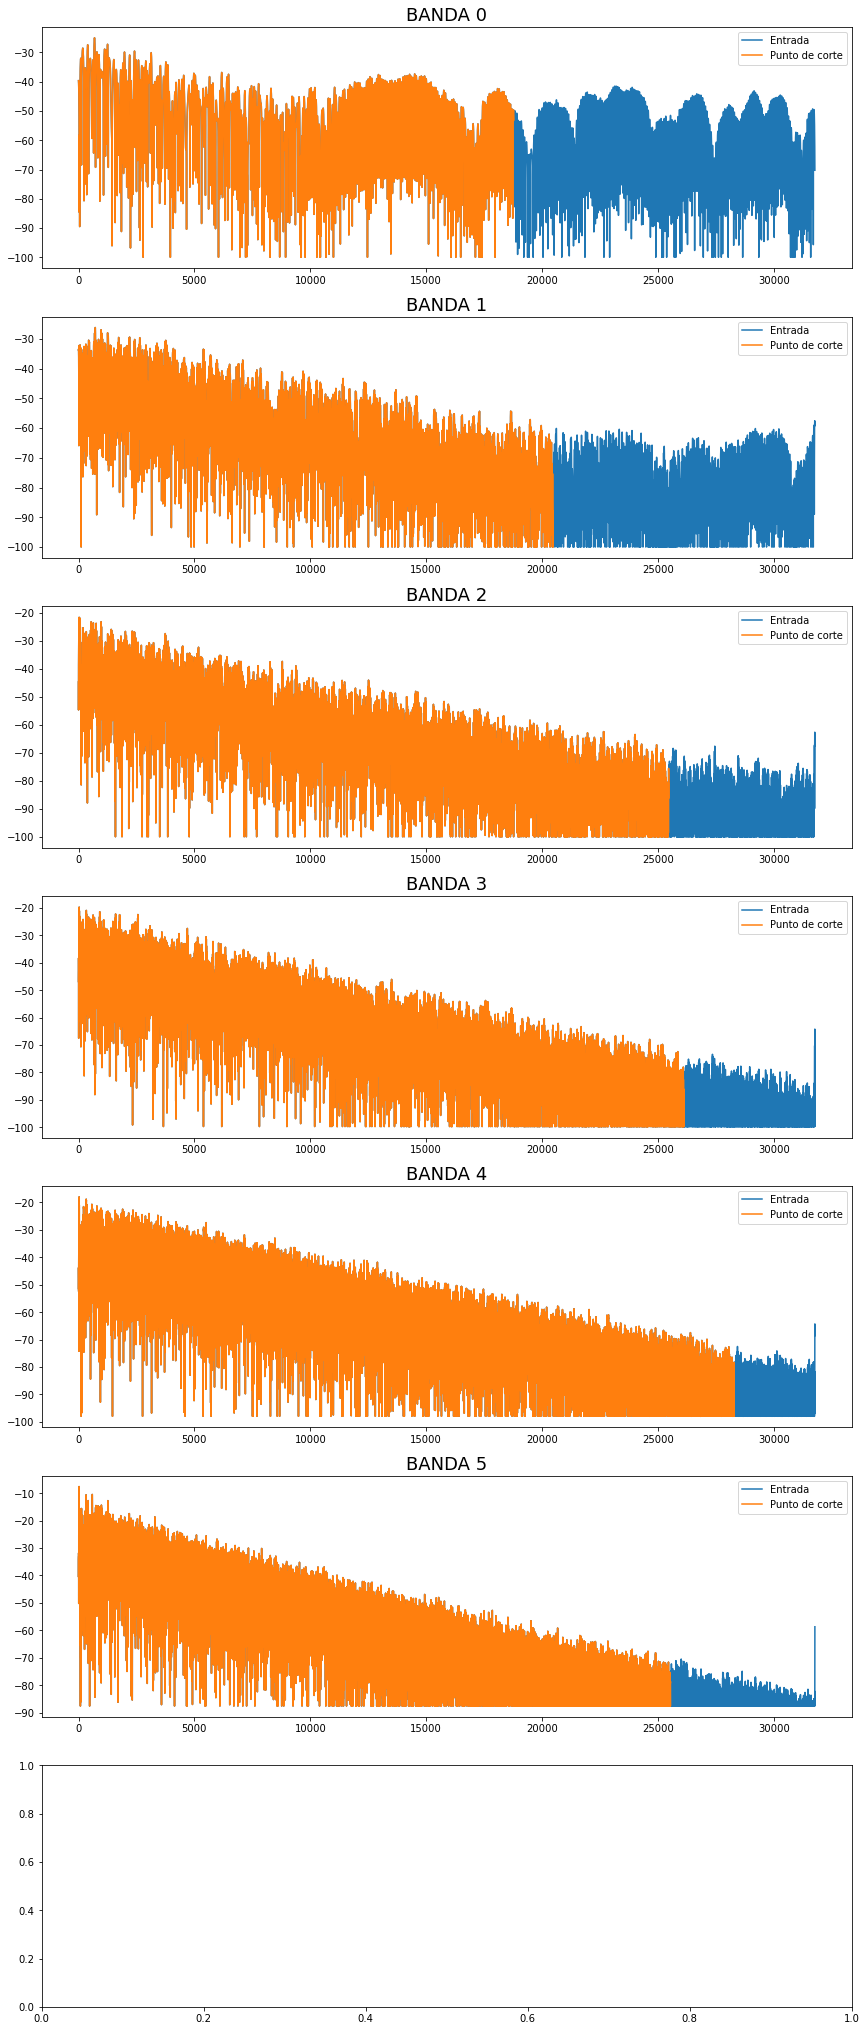

In [19]:
def get_envelope(arr, window_lenght):
    #VER DE CAMBIAR MAX POR MEAN Y MEDIAN
    #arr = Series(arr).apply(lambda x:x**2)
    arr = Series(arr).apply(lambda x:abs(x))
    arr_mean = arr.rolling(window=window_lenght,min_periods=1,center=True).max()
    assert len(arr)==len(arr_mean)
    return arr_mean.to_numpy()

def get_valid_interval(arr, init_value, final_value):
    samples = np.arange(len(arr))
    onset = np.where(arr < init_value)[0][0]
    arr_aux = arr[onset:]

    final = np.where(arr_aux < final_value)[0][0]
    arr_aux2 = arr_aux[:final]

    offset = len(arr) - len(arr_aux)
    samples = samples[onset:(final+offset)]
    return arr_aux2, samples

def Lundeby_method(rir, fs, banda, axs):
    print('Banda: '+str(banda))
    #constantes
    EPS = np.finfo(float).eps
    TIME_INTERVAL = 160 #10 ms
    DISTANCIA_AL_PISO = 5
    N_INTERVALOS_10DB = 10
    DISTANCIA_AL_CRUCE = 5
    RANGO_DINAMICO = 10
    
    #Delay direct
    max_idx = np.argmax(abs(rir))
    
    if max_idx == 0:
        ADD_INIT = False
        rir = rir
    else:
        ADD_INIT = True
        delay = rir[:max_idx]
        rir = rir[max_idx:]

    #Envolvente de la señal al cuadrado
    env = get_envelope(rir, TIME_INTERVAL)
    rir_squared = rir**2
    rir_db = 10*np.log10(rir_squared+EPS)
    env_db = 10*np.log10(env+EPS)
    n = np.arange(len(env_db))

    #Primera estimacion usando el 10%
    noise_floor = env[-int(len(env)*0.1):].mean()
    noise_floor_db = 10*np.log10(noise_floor)

    init_value = env_db.max()
    final_value = noise_floor_db + DISTANCIA_AL_PISO
    
    env_db_chunk, n_chunk = get_valid_interval(env_db, init_value, final_value)
    
    slope, intercept = linear_regression(n_chunk, env_db_chunk)

    cross_point = int((noise_floor_db - intercept)/slope)

    time_interval = int((-10/slope)/N_INTERVALOS_10DB)

    env = get_envelope(rir, time_interval)

    #Segmento para calcular el nuevo piso de ruido
    iteracion = 0
    delta_level = 1.0

    while (iteracion <6 and delta_level > 0.2):
        
        #limito el punto de cruce al largo del audio
        if cross_point > len(env_db)-1:
            cross_level_1 = env_db[-1]
        else:
            cross_level_1 = env_db[cross_point]

        noise_floor_db = get_noise_level(cross_point, slope, env, DISTANCIA_AL_CRUCE)

        init_value = noise_floor_db + DISTANCIA_AL_PISO
        if init_value - RANGO_DINAMICO < np.min(env_db):
            print('PASA')
            final_value = env_db[-2]
        else:
            final_value = init_value - RANGO_DINAMICO
        
        env_db_chunk, n_chunk = get_valid_interval(env_db, init_value, final_value)
        slope, intercept = linear_regression(n_chunk, env_db_chunk)
        
        if banda == 2 & iteracion ==2:
            print('noise floor db: '+str(noise_floor_db))
            print('init_value: '+str(init_value))
            print('final_value: '+str(final_value))
            #plt.plot(env_db_chunk)
            #print(env_db_chunk.shape)
            print(env_db.shape)
            plt.plot(env_db)
            
        cross_point = int((noise_floor_db - intercept)/slope)
        
        if cross_point > len(env_db)-1:
            cross_level_2 = env_db[-1]
        else:
            cross_level_2 = env_db[cross_point]

        delta_level = abs(cross_level_1 - cross_level_2)
        iteracion += 1
        
    rir_cut = rir[:cross_point]
    
    if ADD_INIT:
        rir_salida = np.concatenate((delay, rir_cut))
        rir_plot = np.concatenate((delay, rir))
    else:
        rir_salida = rir_cut
        rir_plot = rir
        
    cross_point_compensado = len(rir_salida)
    axs[banda].plot(librosa.amplitude_to_db(rir_plot), label='Entrada')
    axs[banda].plot(librosa.amplitude_to_db(rir_salida), label='Punto de corte')
    axs[banda].legend()
    axs[banda].set_title('BANDA '+str(banda), fontsize=18)
    return cross_point_compensado

cross_points = []

fig, axs = plt.subplots(7)
for banda in range(rir_bands.shape[0]):
    cross_point = Lundeby_method(rir_bands[banda,:], fs, banda, axs)
    cross_points.append(cross_point)
plt.subplots_adjust(right=2, top=7)

Con esto obtuve los puntos de cruce por cada banda. Con esta informacion, ahora tengo que estimar los parametros de las envolventes para cada banda. El modelo a ajustar contempla la existencia de un piso de ruido. 

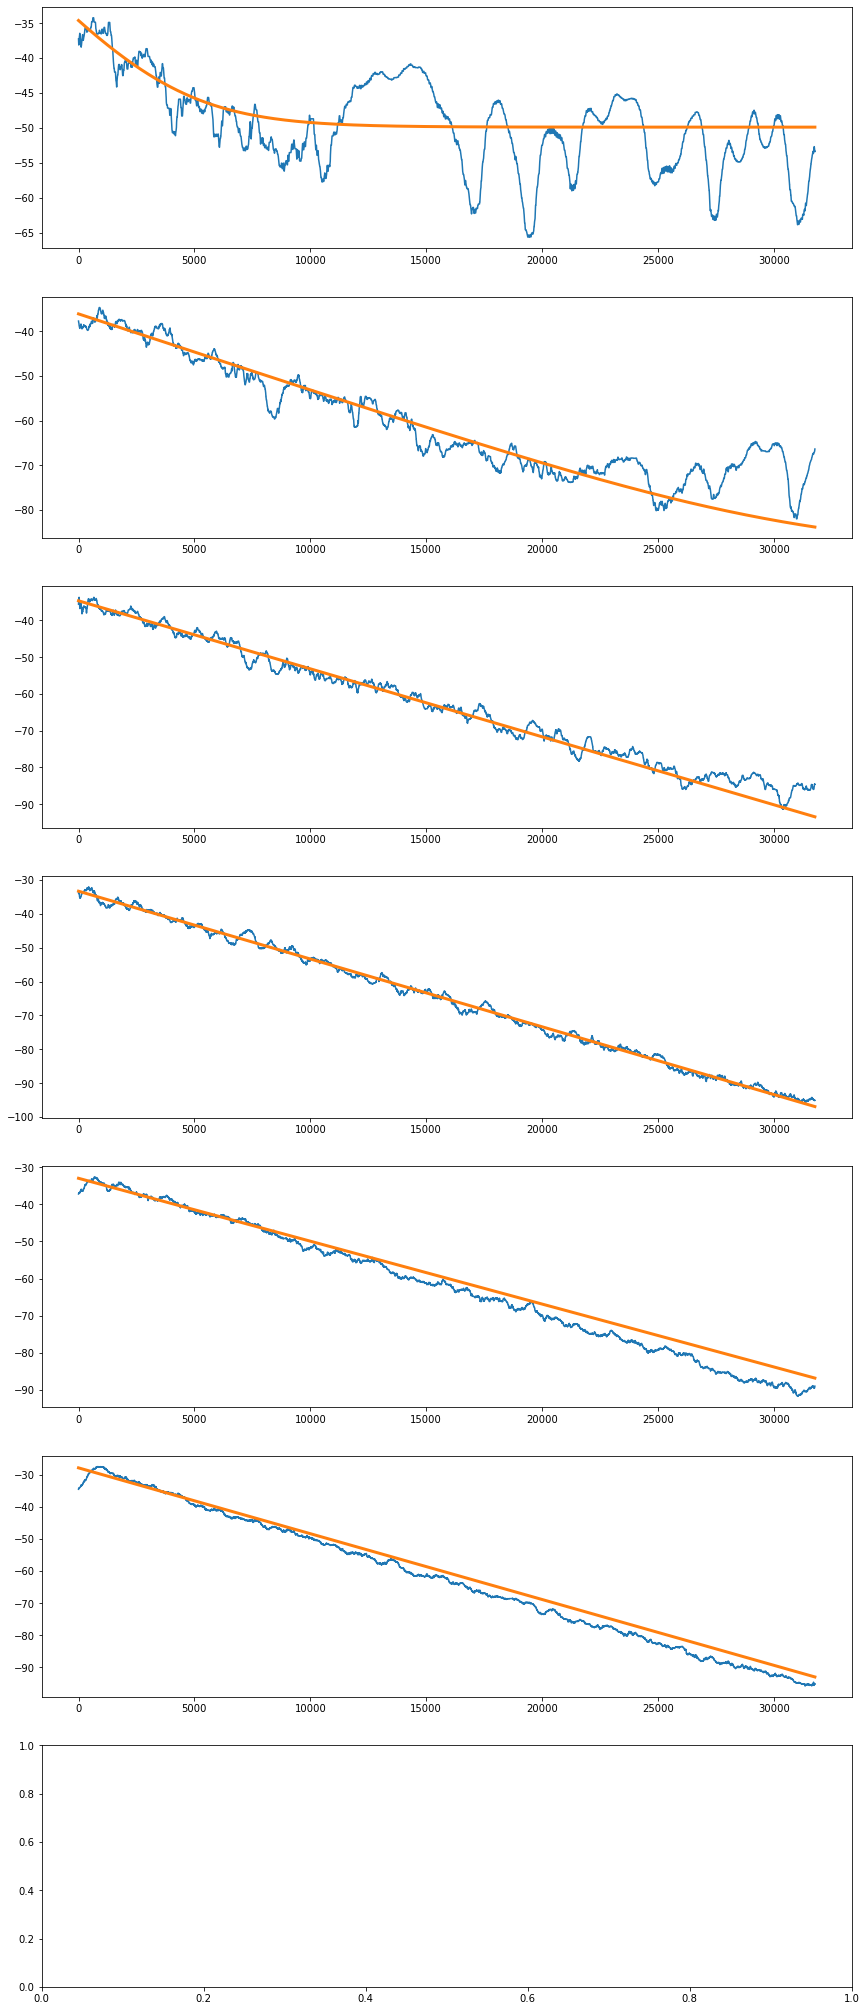

In [78]:
def curva_modelo(t, Am, decay_rate, noise_floor):
    ones = np.ones(len(t))
    modelo = Am * np.exp(-t/decay_rate) * ones + (noise_floor*ones)
    return modelo

def get_abs_max_envelope(arr, window_lenght = 500):
    arr = Series(arr).apply(lambda x:abs(x))
    arr_mean = arr.rolling(window=window_lenght,min_periods=1,center=True).median()
    assert len(arr)==len(arr_mean)
    return arr_mean.to_numpy()

def estim_params(late, cross_point, banda, axs):
    late_env = get_abs_max_envelope(late) # window lenght = 40
    late_env_valid = late_env
    #late_env_valid = late_env[:cross_point]
    #ESTOY HACIENDO LA ESTIMACION SOLO CON LO QUE NO TIENE RUIDO.(LATE ENV VALID)
    t = np.linspace(0, len(late_env_valid)/fs, len(late_env_valid))
    t_entera = np.linspace(0, len(late_env)/fs, len(late_env))
    popt, popv = scipy.optimize.curve_fit(curva_modelo, t, late_env_valid, bounds=(0,1))
    
    estim_params = {'Am':popt[0], 'decay_rate':popt[1], 'noise_floor':popt[2]} 
   
    
    axs[banda].plot(librosa.amplitude_to_db(late_env_valid), label='Envolvente a estimar')
    axs[banda].plot(librosa.amplitude_to_db(curva_modelo(t_entera, **estim_params)), linewidth=3, label='Estimacion parametrica')
    
    return estim_params
fig, axs = plt.subplots(7)
estim_params_list = []
for banda in range(rir_bands.shape[0]):
    parameters = estim_params(rir_bands[banda,:], cross_points[banda], banda, axs)
    estim_params_list.append(parameters)
plt.subplots_adjust(right=2, top=7)

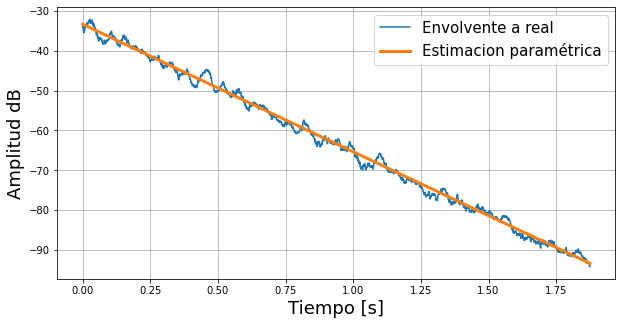

In [36]:
# ploteo la de 1K
def estim_params(late, cross_point, banda, axs):
    late_env = get_abs_max_envelope(late) # window lenght = 40
    late_env_valid = late_env
    #late_env_valid = late_env[:cross_point]
    #ESTOY HACIENDO LA ESTIMACION SOLO CON LO QUE NO TIENE RUIDO.(LATE ENV VALID)
    t = np.linspace(0, len(late_env_valid)/fs, len(late_env_valid))
    t_entera = np.linspace(0, len(late_env)/fs, len(late_env))
    popt, popv = scipy.optimize.curve_fit(curva_modelo, t, late_env_valid, bounds=(0,1))
    
    estim_params = {'Am':popt[0], 'decay_rate':popt[1], 'noise_floor':popt[2]} 
   
    t = np.linspace(0,30000/16000,30000)
    axs.plot(t,librosa.amplitude_to_db(late_env_valid)[:30000], label='Envolvente a real')
    axs.plot(t,librosa.amplitude_to_db(curva_modelo(t_entera, **estim_params))[:30000], linewidth=3, label='Estimacion paramétrica')
    axs.legend(prop={'size': 15})
    axs.set_ylabel('Amplitud dB', fontsize=18)
    axs.set_xlabel('Tiempo [s]', fontsize=18)
    axs.grid()
    plt.savefig('imagenes/estimacion.png')
    return estim_params
fig, axs = plt.subplots(1, figsize=(10,5))
estim_params_list = []
for banda in [3]:
    parameters = estim_params(rir_bands[banda,:], cross_points[banda], banda, axs)
    estim_params_list.append(parameters)


Ahora, la idea es modificar esa curva parametrica estimada para que tenga piso de ruido cero, y usarla para modular una señal de ruido (media = 0 y desvio = 1) 

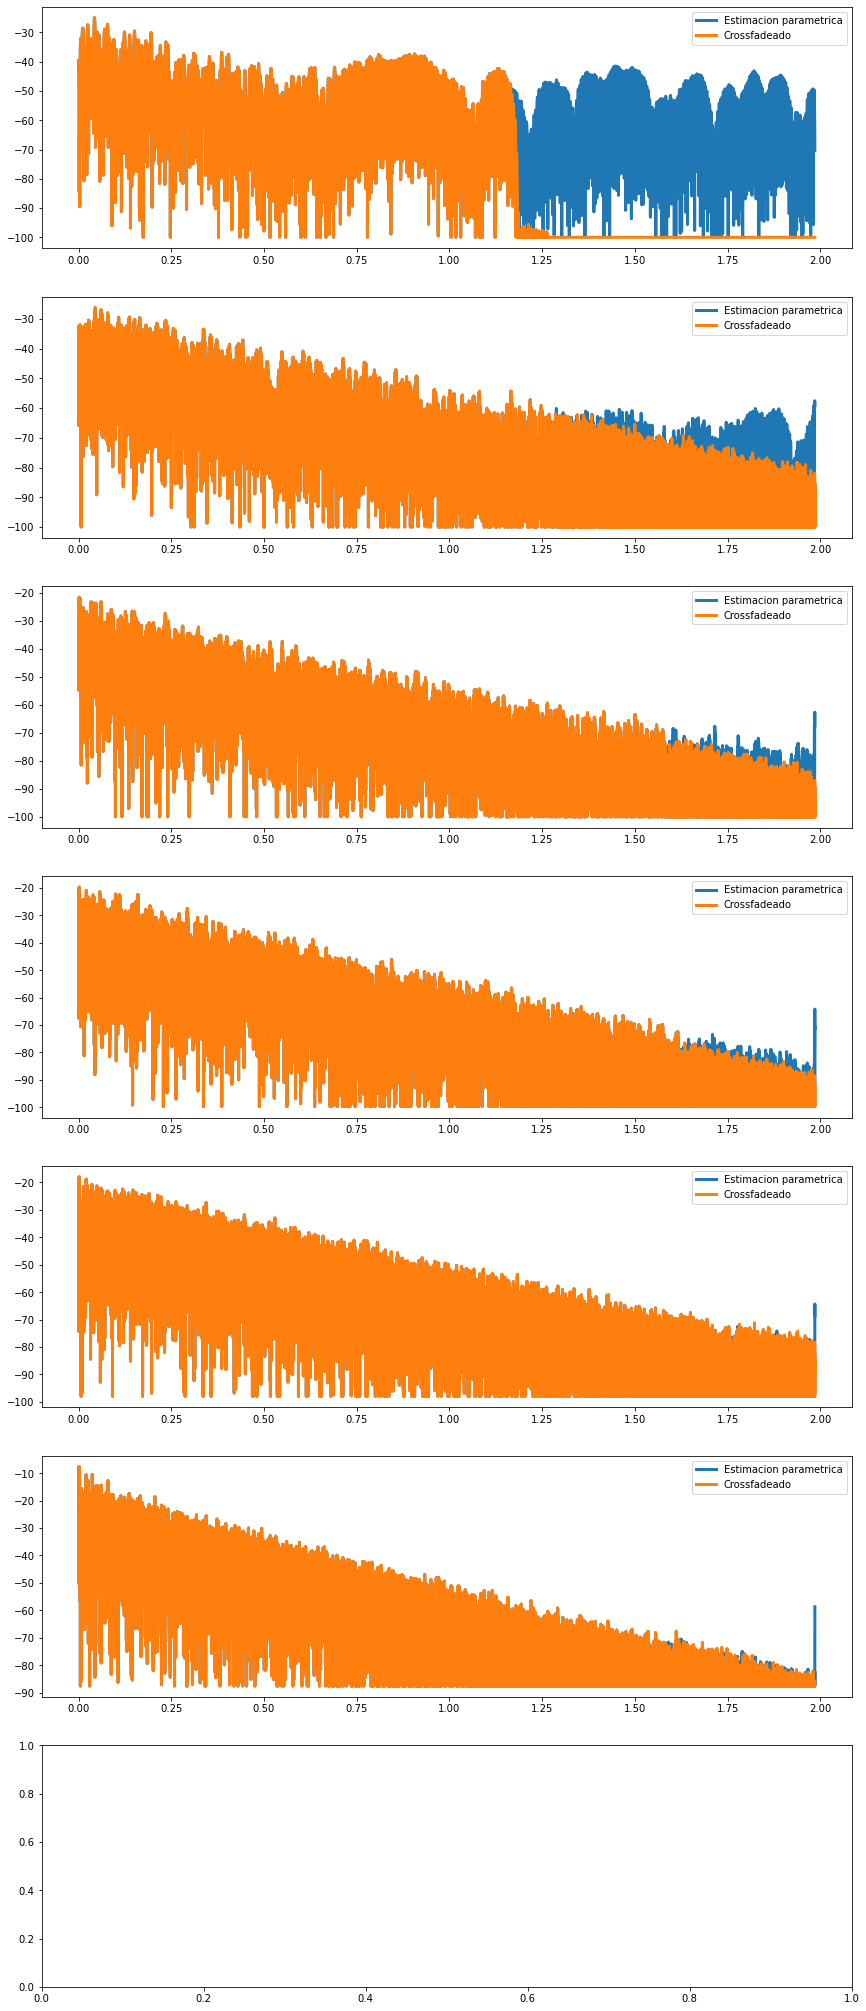

In [79]:
def curva_noiseless(t, Am, decay_rate):
    #noise = np.random.normal(0,1,len(t))
    noise = np.random.normal(0,1,len(t))
    modelo = Am * np.exp(-t/decay_rate) * noise
    return modelo

def cross_fade(señal_1, señal_2, fs, cross_point):
    """
    señal 1 se atenua luego del cross point
    señal 2 se amplifica luego del cross point
    """
    #print(str(len(señal_1)) +'  '+str(len(señal_2))+'  '+str(cross_point))
    largo = int(50 * 0.001 * 16000) # 800 muestras
    if 2*largo > len(señal_1)-cross_point:
        #print('NO CROSSFADEA')
        return señal_1
    ventana = scipy.signal.hann(largo)
    fade_in, fade_out = ventana[:int(largo/2)], ventana[int(largo/2):]
    
    ventana_atenuante = np.concatenate((np.ones(cross_point-int(fade_out.size/2)),
                                        fade_out,
                                        np.zeros(len(señal_1)-cross_point-int(fade_out.size/2))))

    ventana_amplificadora = np.concatenate((np.zeros(cross_point-int(fade_out.size/2)),
                                            fade_in, 
                                            np.ones(len(señal_2)-cross_point-int(fade_out.size/2))))
    return (señal_1*ventana_atenuante) + (señal_2*ventana_amplificadora)

def noise_crossfade(rir, estim_params, cross_point, axs, banda):
    t = np.linspace(0, len(rir)/fs, len(rir))
    rir_noiseless = curva_noiseless(t, estim_params['Am'], estim_params['decay_rate'])
    rir_denoised = cross_fade(rir, rir_noiseless, fs, cross_point)
    
    axs[banda].plot(t,librosa.amplitude_to_db(rir_bands[banda,:]), linewidth=3, label='Estimacion parametrica')
    #axs[banda].plot(t,librosa.amplitude_to_db(rir_noiseless), label='Envolvente sin ruido')
    #axs[banda].plot(t,librosa.amplitude_to_db(curva_modelo(t, **estim_params)), linewidth=3, label='Estimacion parametrica')
    axs[banda].plot(t,librosa.amplitude_to_db(rir_denoised), linewidth=3, label='Crossfadeado')
    axs[banda].legend()
    return rir_denoised
    
fig, axs = plt.subplots(7)
rir_bands_denoised = np.empty(rir_bands.shape)
for banda in range(rir_bands.shape[0]):
    rir_bands_denoised[banda,:] = noise_crossfade(rir_bands[banda,:], estim_params_list[banda], cross_points[banda], axs, banda)
    
plt.subplots_adjust(right=2, top=7)

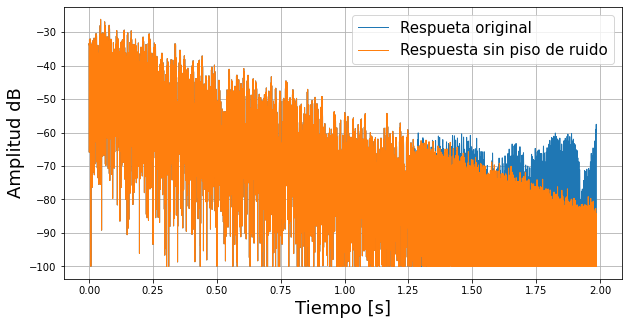

In [63]:
#ploteo la de 1k
def noise_crossfade(rir, estim_params, cross_point, axs, banda):
    t = np.linspace(0, len(rir)/fs, len(rir))
    rir_noiseless = curva_noiseless(t, estim_params['Am'], estim_params['decay_rate'])
    rir_denoised = cross_fade(rir, rir_noiseless, fs, cross_point)
    
    axs.plot(t,librosa.amplitude_to_db(rir_bands[banda,:]), linewidth=1, alpha=1, label='Respueta original')
    #axs[banda].plot(t,librosa.amplitude_to_db(rir_noiseless), label='Envolvente sin ruido')
    #axs[banda].plot(t,librosa.amplitude_to_db(curva_modelo(t, **estim_params)), linewidth=3, label='Estimacion parametrica')
    axs.plot(t,librosa.amplitude_to_db(rir_denoised), linewidth=1,alpha=1, label='Respuesta sin piso de ruido')
    axs.legend(prop={'size': 15})
    axs.set_ylabel('Amplitud dB', fontsize=18)
    axs.set_xlabel('Tiempo [s]', fontsize=18)
    axs.grid()
    plt.savefig('imagenes/recorte_ruido.png')
    return rir_denoised
    
fig, axs = plt.subplots(1, figsize=(10,5))
rir_bands_denoised = np.empty(rir_bands.shape)
for banda in [1]:
    rir_bands_denoised[banda,:] = noise_crossfade(rir_bands[banda,:], estim_params_list[banda], cross_points[banda], axs, banda)
    


Para la banda mas baja las estimaciones no son muy buenas. y probablemente mucho tenga que ver con la calidad en baja frecuencia con la que se realizo la medicion de esta respuesta al impulso. (Por ejemplo, la incapacidad de generar un nivel suficiente de energia en bajas frecuencias). Es por eso que las estimaciones van a tender a estimar TR mas cortos, produciendo que la aumentacion no respete tanto el valor deseado en bajas frecuencias. Para resolverlo se podria hacer un analisis por separado de lo que ocurre en bajas frecuencias pero dependera mucho de cada respuesta. Sin dudas la forma mas sencilla de evitar estos problemas es obteniendo respuestas al impulso que hayan sido obtenidas de manera rigurosa conforme a las indicaciones de las normativas. 

El siguiente paso es aumentar las banda multiplicandolas por la envolvente calculada para variar el decay. Luego, las bandas se suman, se agrega el delay inicial y la parte early y asi termina el proceso de aumentacion 

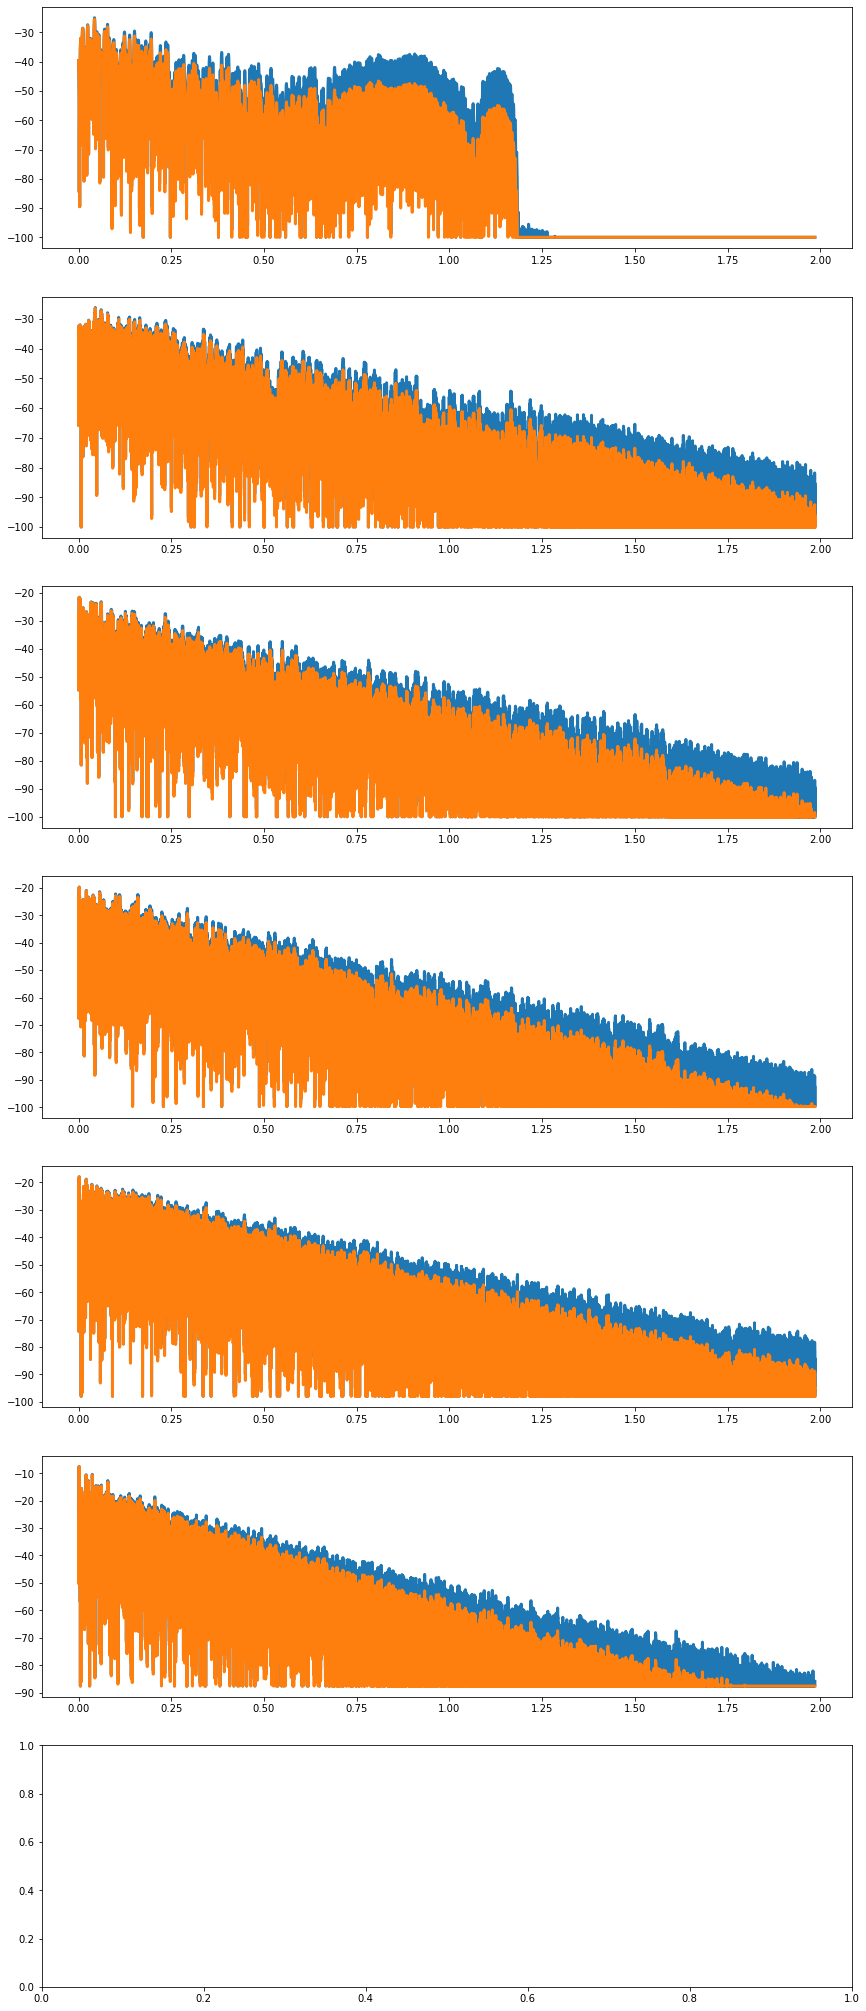

In [80]:
def augmentation(rir, estim_params, estim_fullband_decay ,TR60_desired, axs):
    
    t = np.linspace(0, len(rir)/fs, len(rir))
    decay_rate_d = TR60_desired / (np.log(1000))
    ratio = decay_rate_d / estim_fullband_decay
    t_md = ratio * estim_params['decay_rate']

    #Augmentation
    rir_aug = rir * np.exp(-t*((estim_params['decay_rate']-t_md)/(estim_params['decay_rate']*t_md)))
    
    axs.plot(t,librosa.amplitude_to_db(rir), linewidth=3, label='Original')
    axs.plot(t,librosa.amplitude_to_db(rir_aug), linewidth=3, label='Aug')

    return rir_aug

fig, axs = plt.subplots(7)
rir_bands_aug = np.empty(rir_bands.shape)
for banda in range(rir_bands.shape[0]):
    rir_bands_aug[banda,:] = augmentation(rir_bands_denoised[banda,:], estim_params_list[banda], estim_fullband_decay ,TR_DESEADO, axs[banda])

rir_aug = np.sum(rir_bands_aug, axis=0)
rir_aug = np.concatenate((delay, early, rir_aug))
plt.subplots_adjust(right=2, top=7)

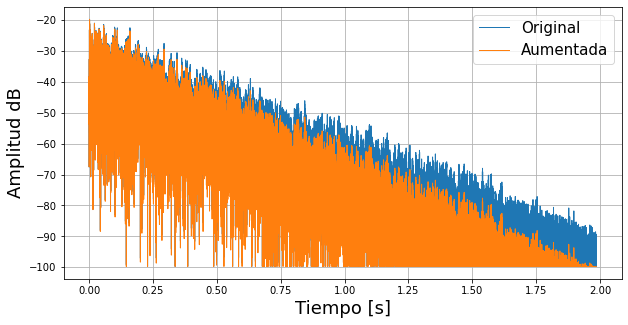

In [75]:
#ploteo la de 1k
def augmentation(rir, estim_params, estim_fullband_decay ,TR60_desired, axs):
    
    t = np.linspace(0, len(rir)/fs, len(rir))
    decay_rate_d = TR60_desired / (np.log(1000))
    ratio = decay_rate_d / estim_fullband_decay
    t_md = ratio * estim_params['decay_rate']

    #Augmentation
    rir_aug = rir * np.exp(-t*((estim_params['decay_rate']-t_md)/(estim_params['decay_rate']*t_md)))
    
    axs.plot(t,librosa.amplitude_to_db(rir), linewidth=1, label='Original')
    axs.plot(t,librosa.amplitude_to_db(rir_aug), linewidth=1, label='Aumentada')
    axs.legend(prop={'size': 15})
    axs.set_ylabel('Amplitud dB', fontsize=18)
    axs.set_xlabel('Tiempo [s]', fontsize=18)
    axs.grid()
    plt.savefig('imagenes/banda_aumentada.png')
    return rir_aug

fig, axs = plt.subplots(1, figsize=(10,5))
rir_bands_aug = np.empty(rir_bands.shape)
for banda in [3]:
    rir_bands_aug[banda,:] = augmentation(rir_bands_denoised[banda,:], estim_params_list[banda], estim_fullband_decay ,TR_DESEADO, axs)

rir_aug = np.sum(rir_bands_aug, axis=0)
rir_aug = np.concatenate((delay, early, rir_aug))

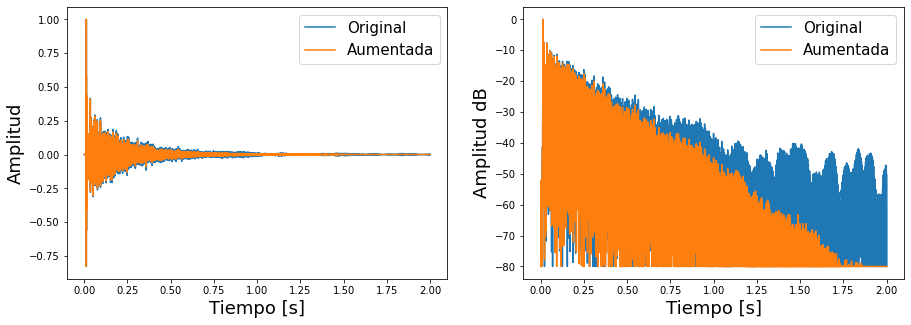

In [90]:
t = np.linspace(0,len(rir_aug)/16000, len(rir_aug))
plt.figure(1, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(t,np.concatenate((delay, early, rir)), label='Original')
plt.plot(t,rir_aug, label='Aumentada')
plt.legend(prop={'size': 15})
plt.xlabel('Tiempo [s]', fontsize=18)
plt.ylabel('Amplitud', fontsize=18)

plt.subplot(1,2,2)
plt.plot(t,librosa.amplitude_to_db(np.concatenate((delay, early, rir))),label='Original')
plt.plot(t,librosa.amplitude_to_db(rir_aug),label='Aumentada')
plt.legend(prop={'size': 15})
plt.xlabel('Tiempo [s]', fontsize=18)
plt.ylabel('Amplitud dB', fontsize=18)
plt.savefig('imagenes/tr_aug.png')

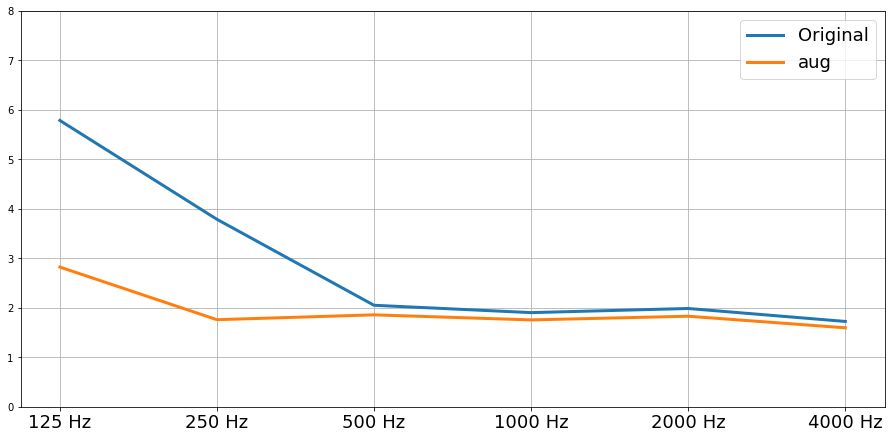

In [18]:
sf.write('rir_aug.wav', rir_aug, 16000)
#tiempo de reverb
bandas = acoustics.bands.octave(125, 4000)

tr = acoustics.room.t60_impulse(audio_list[0], bandas)
tr2 = acoustics.room.t60_impulse('rir_aug.wav', bandas)

ticks_labels = [str(int(i))+' Hz' for i in bandas]
plt.plot(tr, label = 'Original', linewidth = 3)
plt.plot(tr2, label='aug', linewidth = 3)
plt.xticks([0,1,2,3,4,5], ticks_labels, size=18)
plt.legend(prop={'size': 18})
plt.grid()
plt.ylim(0,8)
#print(path.split('/')[-3]+'  '+path.split('/')[-1])
plt.subplots_adjust(right=2, top=1.5, left=0)

# Probando funcion integrada 

In [39]:
from tr_augmentation import tr_augmentation
import librosa
import matplotlib.pyplot as plt
rir_path = '/mnt/datasets/impulsos/reales/C4DM'
audio_list = get_audio_list(rir_path)
path = audio_list[345]
rir_entrada, fs = librosa.load(path, sr=16000)
params = {'fc' : [125.0, 250.0, 500.0, 1000.0, 2000.0, 4000.0, 8000.0],
          'fs' : 16000,
          'filter_order' : 4,
          'filter_length' : 16384,
          'power' : True}
TR_DESEADO = 1.6

In [40]:
rir_aug, fs = tr_augmentation(rir_entrada, fs, 1.0)

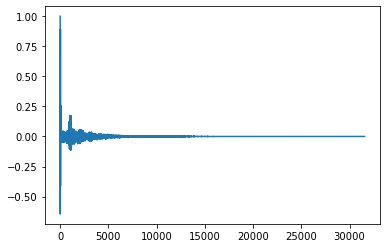

In [41]:
plt.plot(rir_aug)